In [3]:
import torchvision
import torch 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.dataloader import DataLoader
from mydataset import OmniglotDataset, acc
import random

import copy

nways = 4

In [4]:
bsize = 8
ksize = 5
dataset = OmniglotDataset(k=ksize+1, n=nways, ntrain=800, is_train=True)
dataset_test = OmniglotDataset(k=ksize, n=nways, ntrain=800, is_train=False)

loader = torch.utils.data.DataLoader(dataset, batch_size=bsize, num_workers=3)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=bsize, num_workers=3)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
class Model(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.pixs = 27**2
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 32, 3)
        self.pad   = nn.ZeroPad2d(1)

        self.pool = nn.MaxPool2d(2)
        self.lin1 = nn.Linear(512, 32)
        self.lin2 = nn.Linear(32, nways)

    def forward(self, x):
        x0 = x.shape
        x = x.view(-1, 1, x.shape[-2], x.shape[-1])
        h = self.conv1(x)
        h = self.pool(h)
        h = F.relu(h)

        h = self.conv2(h)
        h = self.pool(h)
        h = F.relu(h)

        h2 = self.pad(h)
        h2 = self.conv3(h2)
        h2 = F.relu(h2)
        h = h + h2

        h = h.view(h.shape[0], -1)
        h = self.lin1(h)
        h = F.relu(h)
        h = self.lin2(h)
        h = torch.softmax(h, dim=-1)
        return h.view(x0[0], x0[1], h.shape[-1])
model = Model()

In [7]:
def reptile_optimize(model, intrain, targtrain, intest, targtest, lr, n, alfa=0.95, update_model=True):
    cumloss, cummacc = 0, 0
    for x_train, y_train, x_test, y_test in zip(intrain, targtrain, intest, targtest):
        model_copy = copy.deepcopy(model)
        opt = torch.optim.Adam(model_copy.parameters(), lr=lr)
        for i in range(n):
            preds = model_copy(x_train)
            loss = -(y_train*torch.log(preds+1e-8)).mean()
            if i == 2:
                cumloss += loss.item()
            opt.zero_grad()
            loss.backward()
            opt.step()
        if update_model:
            polyak(model_copy, model, alfa=alfa)
        preds = model_copy(x_test)
        cummacc += acc(y_test, preds)
    return cumloss/intrain.shape[0], cummacc/intrain.shape[0], preds


def polyak(a, b, alfa=0.99):
    for namea, parama in a.named_parameters():
        for nameb, paramb in b.named_parameters():
            if namea == nameb:
                paramb.data = paramb.data*alfa + parama.data*(1-alfa)
    return b 

In [9]:
eps=1
ii = 0
model = Model()

writer = SummaryWriter('tb/reptile_k=3_nways=5_withtest_n_2____')
for ep in range(eps):
    for step, (x, y) in enumerate(loader):
        xexamples, xtoguess = x[:, :-1], x[:, -1].unsqueeze(1)
        yexamples, ytoguess = y[:, :-1], y[:, -1].unsqueeze(1)
        loss, accuraccy, _ = reptile_optimize(model, xexamples, yexamples, xtoguess, ytoguess, 1e-2, 5, 0.9)
        writer.add_scalar('metric/loss', loss, ii:=ii+1)
        writer.add_scalar('metric/accu', accuraccy, ii)
        import time 
        # time.sleep(3) 
        print(ep, step, loss, accuraccy)

0 0 0.3369314484298229 0.4375
0 1 0.28913454711437225 0.59375
0 2 0.29821738600730896 0.65625
0 3 0.27571772038936615 0.84375
0 4 0.2581358812749386 0.6875
0 5 0.2516357507556677 0.84375
0 6 0.21478266827762127 0.78125
0 7 0.21648345701396465 0.875
0 8 0.17975743673741817 0.875
0 9 0.19358842261135578 0.78125
0 10 0.173060005530715 0.6875
0 11 0.20070227794349194 0.75
0 12 0.18226491007953882 0.71875
0 13 0.14568691328167915 0.84375
0 14 0.14241887163370848 0.8125
0 15 0.16354503016918898 0.71875
0 16 0.12860088306479156 0.875
0 17 0.1338181495666504 0.875
0 18 0.16367148514837027 0.84375
0 19 0.12384563405066729 0.84375
0 20 0.11426100833341479 0.84375
0 21 0.147649553604424 0.9375
0 22 0.1311319642700255 0.9375
0 23 0.0830751322209835 0.875
0 24 0.1477058557793498 0.90625
0 25 0.09847186738625169 0.84375
0 26 0.1418451238423586 0.875
0 27 0.11078762076795101 0.84375
0 28 0.07916619721800089 0.84375
0 29 0.09436758211813867 0.9375
0 30 0.10321272118017077 0.875
0 31 0.1024872562848031

KeyboardInterrupt: 

In [20]:
for x, y in loader_test:
    break
xexamples, xtoguess = x[0, :-1].unsqueeze(0), x[0, -1].unsqueeze(0).unsqueeze(1)
yexamples, ytoguess = y[0, :-1].unsqueeze(0), y[0, -1].unsqueeze(0).unsqueeze(1)
reptile_optimize(model, xexamples, yexamples, xtoguess, ytoguess, 1e-2, 5, 0.9, update_model=False)

(0.011526895686984062,
 1.0,
 tensor([[[9.9974e-01, 9.5056e-06, 2.4693e-04, 4.0532e-07],
          [3.5687e-06, 9.9985e-01, 2.9120e-05, 1.1435e-04],
          [9.9443e-05, 7.5067e-03, 9.9104e-01, 1.3498e-03],
          [6.1208e-07, 2.3489e-06, 4.0443e-06, 9.9999e-01]]],
        grad_fn=<ViewBackward>))

In [22]:
xexamples.shape

torch.Size([1, 4, 4, 27, 27])

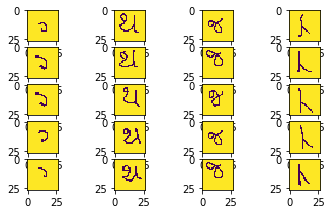

In [19]:
br = 0
for i, kx in enumerate(torch.cat((xexamples[0], xtoguess[0]), dim=0)):
    for j, x in enumerate(kx):
        plt.subplot(ksize+1, nways, br := br+1)
        plt.imshow(x.numpy())